# C — RHS generation (randomized sources)

Goal: generate a **reproducible** family of randomized right-hand sides (RHS) for the Helmholtz problem,
to be used for:

- **training** (direct solves)
- **testing**
- later: iterative refinement / preconditioning experiments

## Convention
You write the **smaller** frequency as $\omega'$ and the **larger** frequency as $\omega$.
In this notebook we use:

- $\omega' = 32$
- $\omega = 64$

## What lives in `src/`
This notebook contains **no helper functions**. All reusable logic is imported from:

- `src/core/rhs.py`:
  - `RHSConfig`
  - `generate_rhs_batch`
  - `validate_rhs_metas_outside_pml`
- `src/diagnostics.py`:
  - `plot_rhs_grid`
  - `save_npz`

## Exit criteria
- visuals look sane
- strict check: no sources inside PML+margin
- norms behave as expected
- deterministic across runs via `(base_seed, sample_id)`


In [1]:
# --- Imports & project path ---
import sys
from pathlib import Path

import numpy as np

# Add repo root to sys.path (robust upward search)
def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for cand in [p] + list(p.parents):
        if (cand / "pyproject.toml").exists() or (cand / "src").is_dir():
            return cand
    raise RuntimeError(f"Could not find project root starting from {start}")

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)


PROJECT_ROOT = C:\Users\31624\Documents\MIT\Programming\Freq2Transfer


In [2]:
# --- Imports from your framework ---
from src.core.rhs import RHSConfig, generate_rhs_batch, validate_rhs_metas_outside_pml
from src.diagnostics import plot_rhs_grid, save_npz


## 1) Grid / case / configs

This notebook needs:
- `cfg` (HelmholtzConfig) with `cfg.grid.nx`, `cfg.grid.ny` etc. (preferred)
- `case` (CaseConfig) with at least `case.npml` (or your schema that rhs.py can infer)
- `X, Y` arrays with `indexing="ij"`

Below is a minimal **fallback** setup that only provides `omega` and `npml`
(via SimpleNamespace), and builds `X, Y` directly.

> Requirement: **at least 501×501**.


In [3]:
from types import SimpleNamespace

# --- Fallback grid (replace with your real grid builder later) ---
nx, ny = 501, 501
Lx, Ly = 1.0, 1.0

x = np.linspace(0.0, Lx, nx)
y = np.linspace(0.0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# PML thickness in cells (should match your experiment setup)
npml = 24
pml_margin_cells = 2

# Minimal cfg/case objects for RHS generation
cfg_omega_prime = SimpleNamespace(omega=32.0)  # omega'
cfg_omega = SimpleNamespace(omega=64.0)        # omega
case = SimpleNamespace(npml=int(npml))

print(f"Grid: {nx} x {ny}, npml={npml}, margin={pml_margin_cells}")


Grid: 501 x 501, npml=24, margin=2


## 2) RHS configuration

Key for paired data: **do not include omega in the RNG seed**.
Then the same `sample_id` gives the same RHS for $\omega'$ and $\omega$.


In [4]:
rhs_cfg = RHSConfig(
    mode="random_gaussians",
    k_min=1,
    k_max=4,
    amp_dist="uniform",
    amp_scale=1.0,
    complex_amps=True,
    width_min_cells=1.5,
    width_max_cells=5.0,
    avoid_pml=True,
    pml_margin_cells=pml_margin_cells,
    normalize="l2",
    target_norm=1.0,
    base_seed=123,
    include_omega_in_seed=False,  # IMPORTANT for paired (omega', omega)
    zero_boundary=True,
)

rhs_cfg


RHSConfig(mode='random_gaussians', k_min=1, k_max=4, amp_dist='uniform', amp_scale=1.0, complex_amps=True, width_min_cells=1.5, width_max_cells=5.0, avoid_pml=True, pml_margin_cells=2, normalize='l2', target_norm=1.0, base_seed=123, include_omega_in_seed=False, zero_boundary=True)

## 3) Preview batch + sanity checks


In [5]:
N_preview = 16
F_preview, meta_preview = generate_rhs_batch(
    cfg_omega,
    case,
    X,
    Y,
    rhs_cfg=rhs_cfg,
    N=N_preview,
    return_meta=True,
)

print("F_preview:", F_preview.shape)
print("Example meta keys:", list(meta_preview[0].keys()))


C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\rhs.py:106: RuntimeWarning: overflow encountered in scalar multiply
  seed ^= np.uint64(sample_id + 1) * np.uint64(0x9E3779B97F4A7C15)


F_preview: (16, 251001)
Example meta keys: ['mode', 'sample_id', 'npml', 'K', 'centers_ij', 'sigmas_cells', 'amps_re_im', 'norm_scale_applied', 'seed_base', 'include_omega_in_seed', 'rhs_cfg']


In [6]:
validate_rhs_metas_outside_pml(
    meta_preview,
    (nx, ny),
    npml=npml,
    margin=pml_margin_cells,
)

l2_norms = np.linalg.norm(F_preview, axis=1)
print("L2 norms:", l2_norms[:8])
print("min/max:", float(l2_norms.min()), float(l2_norms.max()))


L2 norms: [1. 1. 1. 1. 1. 1. 1. 1.]
min/max: 0.9999999999999996 1.0000000000000002


## 4) Visualize RHS samples

Uses `plot_rhs_grid` from `src/diagnostics.py`.


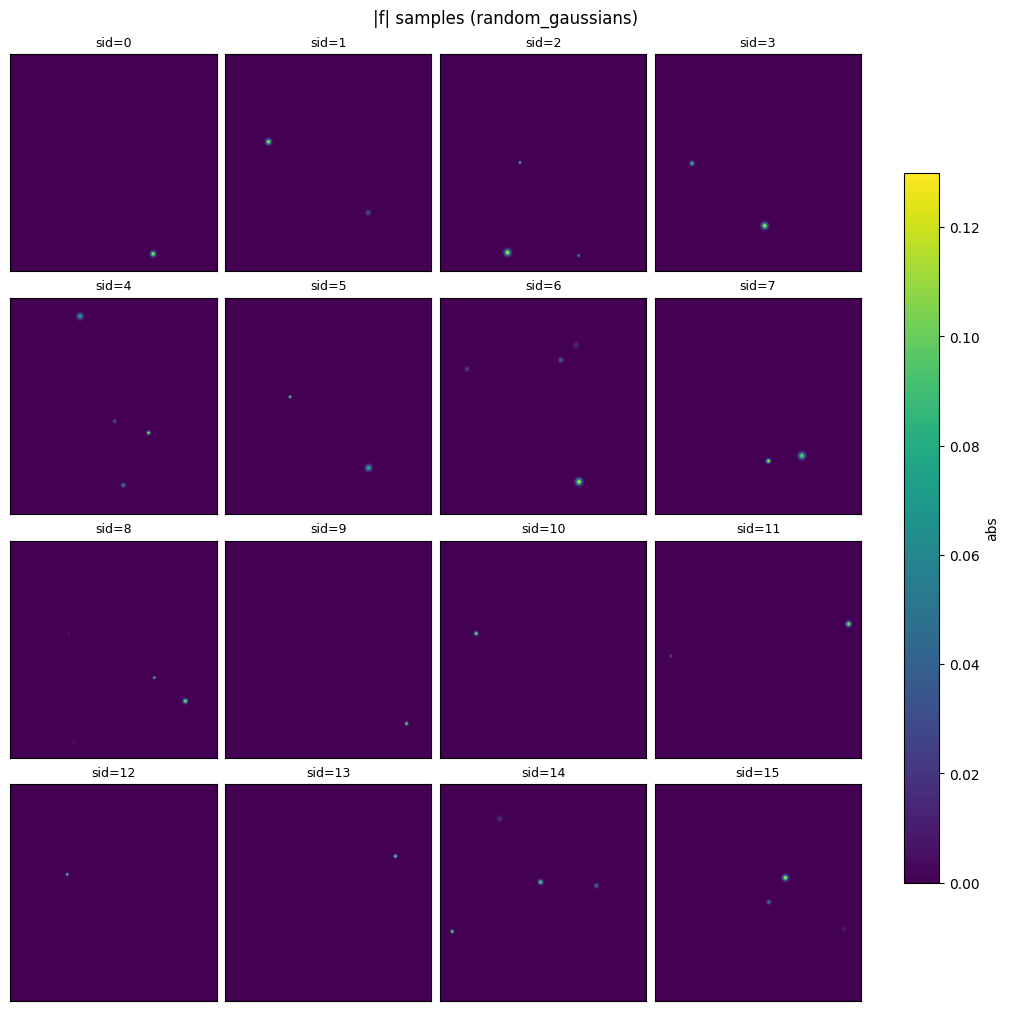

Saved preview plot to: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\outputs\notebookC_rhs\rhs_samples_abs.png


In [7]:
OUTDIR = PROJECT_ROOT / "outputs" / "notebookC_rhs"
OUTDIR.mkdir(parents=True, exist_ok=True)

plot_rhs_grid(
    F_preview,
    grid_shape=(nx, ny),   # using fallback grid; if you pass a real cfg, use cfg=...
    nrows=4,
    ncols=4,
    mode="abs",
    title="|f| samples (random_gaussians)",
    path=OUTDIR / "rhs_samples_abs.png",
    show=True,
)
print("Saved preview plot to:", (OUTDIR / "rhs_samples_abs.png").resolve())


## 5) Generate train/test RHS datasets + save

Saves:
- `train_rhs.npz`, `test_rhs.npz`
- `train_meta.npy`, `test_meta.npy` (metadata list)

(Using `.npy` keeps Python dicts without needing extra JSON handling.)


In [9]:
N_train = 512
N_test = 128

F_train, meta_train = generate_rhs_batch(
    cfg_omega,
    case,
    X,
    Y,
    rhs_cfg=rhs_cfg,
    N=N_train,
    return_meta=True,
)

F_test, meta_test = generate_rhs_batch(
    cfg_omega,
    case,
    X,
    Y,
    rhs_cfg=rhs_cfg,
    N=N_test,
    return_meta=True,
)

validate_rhs_metas_outside_pml(meta_train, (nx, ny), npml=npml, margin=pml_margin_cells)
validate_rhs_metas_outside_pml(meta_test,  (nx, ny), npml=npml, margin=pml_margin_cells)

save_npz(OUTDIR / "train_rhs.npz", F=F_train)
save_npz(OUTDIR / "test_rhs.npz",  F=F_test)

np.save(OUTDIR / "train_meta.npy", np.array(meta_train, dtype=object))
np.save(OUTDIR / "test_meta.npy",  np.array(meta_test, dtype=object))

print("Saved dataset to:", OUTDIR.resolve())


Saved dataset to: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\outputs\notebookC_rhs


## 6) Verify pairing across $(\omega', \omega) = (32, 64)$

Because `include_omega_in_seed=False`, RHS samples are identical for $\omega'$ and $\omega$.


In [10]:
F_a, _ = generate_rhs_batch(cfg_omega_prime, case, X, Y, rhs_cfg=rhs_cfg, N=4, return_meta=False)
F_b, _ = generate_rhs_batch(cfg_omega,       case, X, Y, rhs_cfg=rhs_cfg, N=4, return_meta=False)

diff = float(np.max(np.abs(F_a - F_b)))
print("max |F(ω') - F(ω)| =", diff)

# For purely deterministic generation, this should be exactly zero.
assert diff == 0.0
print("OK: identical RHS across ω' and ω (paired by sample_id).")


max |F(ω') - F(ω)| = 0.0
OK: identical RHS across ω' and ω (paired by sample_id).
